In [1]:
import gzip
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy as sp
from sklearn import manifold
from sklearn import neighbors
import struct

In [2]:
# Parse data from zipped mnist files into numpy arrays
# Modified from source: https://gist.github.com/tylerneylon/ce60e8a06e7506ac45788443f7269e40
#
# Input:  filename --> Zipped file to parse
#
# Output: return   --> Numpy array of unint8 data points
#
def read_idx(filename):
    with gzip.open(filename) as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

In [3]:
# Construct an nxm matrix of evenly distributed samples from an input sample set
#
# Inputs: Y    --> Sample matrix
#         n, m --> Landmark matrix dimensions
#
# Output: idx  --> nxm Landmark matrix
#
def find_landmarks(Y, n, m):
    xr = np.linspace(np.min(Y[:,0]), np.max(Y[:,0]), n)
    yr = np.linspace(np.min(Y[:,1]), np.max(Y[:,1]), m)
    xg, yg = np.meshgrid(xr, yr)
    idx = [0]*(n*m)
    for i, x, y in zip(range(n*m), xg.flatten(), yg.flatten()):
        idx[i] = int(np.sum(np.abs(Y-np.array([x,y]))**2, axis=-1).argmin())
    return idx

In [4]:
# TODO - We only have to implement this function, swap it with the manifold one below
# Seek a low-rank projection on an input matrix
#
# Inputs: X            --> Input matrix to reduce
#         n_neighbors  --> Maximum number of neighbors used for reconstruction
#         n_components --> Maximum number of linearly independent components for reconstruction
#
# Output: Y            --> Reconstructed vectors in a lower rank
#         err          --> (Optional implementation) Error margin of vectors
#
def locally_linear_embedding(X, n_neighbors, n_components):
    
    # Step 1: Find the nearest neighbors at for each sample
    tree = neighbors.BallTree(X, leaf_size=n_components)
    dist, ind = tree.query(X[:1], k=n_neighbors)

    # Step 2: Construct a weighted matrix that recreates X from its neighbors
    
    
    # Step 3: Compute vectors that are reconstructed by weights
    
    
    Y = X[:,0:2]   # placeholder
    err = 0.001    # placeholder
    return Y, err

In [5]:
# Extract mnist data from files
raw_train = read_idx("train-images-idx3-ubyte.gz")
train_data = np.reshape(raw_train, (60000, 28*28))
train_label = read_idx("train-labels-idx1-ubyte.gz")

In [6]:
# Train algorithm and calculate landmark graph
X = train_data[train_label == 8]
Y, err = manifold.locally_linear_embedding(X, n_neighbors=10, n_components=2)
#Y, err = locally_linear_embedding(X, n_neighbors=10, n_components=2)
landmarks = find_landmarks(Y, 5, 5)

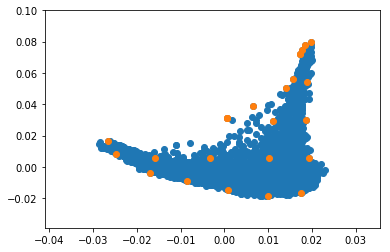

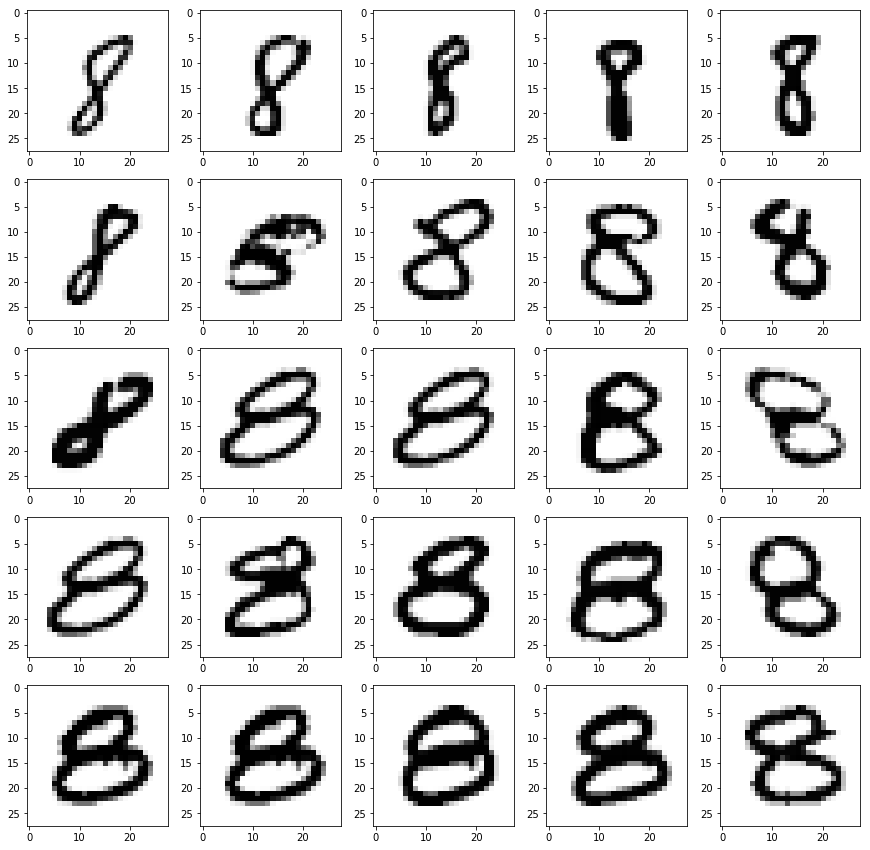

In [7]:
# Plot the clustered data with landmarks overlaid
plt.scatter(Y[:,0], Y[:,1])
plt.scatter(Y[landmarks,0], Y[landmarks,1])

# Show the landmark samples in a 5x5 grid
fig = plt.figure(figsize=(15,15))
for i in range(len(landmarks)):
    ax = fig.add_subplot(5, 5, i+1)
    imgplot = ax.imshow(np.reshape(X[landmarks[i]], (28,28)), cmap=plt.cm.get_cmap("Greys"))
    imgplot.set_interpolation("nearest")
plt.show()